# Домашнее задание 4

## Тема “Классификация текста”

В качестве заготовки для задания прогоним часть 2ого домашнего задания. Нам необходимо получить разреженные матрицы, используя CountVectorizer, TfidfVectorizer для 'tweet_stemmed' и 'tweet_lemmatized' столбцов (4 матрицы).

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn import model_selection, preprocessing, linear_model, naive_bayes
from sklearn import decomposition, svm, ensemble
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import f1_score

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import collections, re, xgboost, textblob, string

from wordcloud import WordCloud

**Выполним подготовку**

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
stop_words = set(nltk.corpus.stopwords.words("english"))

### Задание 1.

Построим модель LogisticRegression, используя Bag-of-Words признаки для столбца combine_df['tweet_stemmed']. 
- Поделим Bag-of-Words признаки на train, test (train заканчивается на 31962 строке combine_df)
- Ответами является столбец train_df['label']
- Рассчитаем predict_proba, приведем prediction в в бинарный вид: если предсказание >= 0.3 то 1, иначе 0, тип заменим на int
- Рассчитаем f1_score 

Повторим аналогично для столбца combine_df['tweet_lemmatized'].



In [4]:
combine_df = pd.read_pickle('combine_df.pkl')
combine_df.head(3)

,id,label,tweet,clean_tweet,tweet_token,tweet_token_filtered,tweet_stemmed,tweet_lemmatized
0,1,0.0,@user when a father is dysfunctional and is s...,when father is dysfunctional and is so selfish...,"[when, father, is, dysfunctional, and, is, so,...","[father, dysfunctional, selfish, drags, kids, ...","[father, dysfunct, selfish, drag, kid, dysfunc...","[father, dysfunctional, selfish, drag, kid, dy..."
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit cannot use cause they d...,"[thanks, for, lyft, credit, can, not, use, cau...","[thanks, lyft, credit, use, cause, offer, whee...","[thank, lyft, credit, use, caus, offer, wheelc...","[thanks, lyft, credit, use, cause, offer, whee..."
2,3,0.0,bihday your majesty,bihday your majesty,"[bihday, your, majesty]","[bihday, majesty]","[bihday, majesti]","[bihday, majesty]"


In [5]:
combine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49159 entries, 0 to 49158
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    49159 non-null  int64  
 1   label                 31962 non-null  float64
 2   tweet                 49159 non-null  object 
 3   clean_tweet           49159 non-null  object 
 4   tweet_token           49159 non-null  object 
 5   tweet_token_filtered  49159 non-null  object 
 6   tweet_stemmed         49159 non-null  object 
 7   tweet_lemmatized      49159 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 3.0+ MB


In [6]:
combine_df = combine_df.dropna()
combine_df.label = combine_df.label.astype(int)

In [7]:
combine_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31962 entries, 0 to 31961
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    31962 non-null  int64 
 1   label                 31962 non-null  int64 
 2   tweet                 31962 non-null  object
 3   clean_tweet           31962 non-null  object
 4   tweet_token           31962 non-null  object
 5   tweet_token_filtered  31962 non-null  object
 6   tweet_stemmed         31962 non-null  object
 7   tweet_lemmatized      31962 non-null  object
dtypes: int64(2), object(6)
memory usage: 2.2+ MB


In [8]:
SIZE = int(len(combine_df) * 0.75)
SIZE

23971

In [9]:
(X_train_stemmed, y_train_stemmed), (X_test_stemmed, y_test_stemmed) = \
    (combine_df.tweet_stemmed.apply(lambda x: ' '.join(x)).values[:SIZE], \
     combine_df.label.tolist()[:SIZE]), \
    (combine_df.tweet_stemmed.apply(lambda x: ' '.join(x)).values[SIZE:], \
     combine_df.label.tolist()[SIZE:])

X_train_stemmed.shape, len(y_train_stemmed), X_test_stemmed.shape, len(y_test_stemmed)

((23971,), 23971, (7991,), 7991)

In [10]:
def train_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_test)
    return f1_score(y_test, preds[:,1]>0.3)

In [11]:
count_vec = CountVectorizer(max_df=0.85, stop_words='english', max_features=1000)
xtrain_stemmed_count_vec = count_vec.fit_transform(X_train_stemmed)
xtest_stemmed_count_vec = count_vec.transform(X_test_stemmed)

clf = linear_model.LogisticRegression()
f1_score_stemmed_count_vec = train_model(
    clf, 
    xtrain_stemmed_count_vec, 
    y_train_stemmed, 
    xtest_stemmed_count_vec, 
    y_test_stemmed)
f1_score_stemmed_count_vec

0.5621052631578947

In [12]:
tfidf_vec = TfidfVectorizer(max_df=0.85, stop_words='english', max_features=5000)
xtrain_stemmed_tfidf_vec = count_vec.fit_transform(X_train_stemmed)
xtest_stemmed_tfidf_vec = count_vec.transform(X_test_stemmed)

clf = linear_model.LogisticRegression()
f1_score_stemmed_tfidf_vec = train_model(
    clf, 
    xtrain_stemmed_tfidf_vec, 
    y_train_stemmed, 
    xtest_stemmed_tfidf_vec, 
    y_test_stemmed)
f1_score_stemmed_tfidf_vec

0.5621052631578947

### Задание 2.

Построим модель LogisticRegression, используя TF-IDF признаки для столбца combine_df['tweet_stemmed']. 
- Поделим TF-IDF признаки на train, test (train заканчивается на 31962 строке combine_df)
- Ответами является столбец train_df['label']
- Рассчитаем predict_proba, приведем prediction в в бинарный вид: если предсказание >= 0.3 то 1, иначе 0, тип заменим на int
- Рассчитаем f1_score 

Повторим аналогично для столбца combine_df['tweet_lemmatized'].


In [13]:
(X_train_lemmatized, y_train_lemmatized), (X_test_lemmatized, y_test_lemmatized) = \
    (combine_df.tweet_lemmatized.apply(lambda x: ' '.join(x)).values[:SIZE], 
     combine_df.label.tolist()[:SIZE]), \
    (combine_df.tweet_lemmatized.apply(lambda x: ' '.join(x)).values[SIZE:], \
     combine_df.label.tolist()[SIZE:])

In [14]:
count_vec = CountVectorizer(max_df=0.85, stop_words='english', max_features=1200)

xtrain_lemmatized_count_vec = count_vec.fit_transform(X_train_lemmatized)
xtest_lemmatized_count_vec = count_vec.transform(X_test_lemmatized)

clf = linear_model.LogisticRegression()

f1_score_lemmatized_count_vec = train_model(
    clf, 
    xtrain_lemmatized_count_vec, 
    y_train_lemmatized, 
    xtest_lemmatized_count_vec, 
    y_test_lemmatized)
f1_score_lemmatized_count_vec

0.5520833333333334

In [15]:
tfidf_vec = TfidfVectorizer(max_df=0.85, stop_words='english', max_features=1000)
xtrain_lemmatized_tfidf_vec = tfidf_vec.fit_transform(X_train_lemmatized)
xtest_lemmatized_tfidf_vec = tfidf_vec.transform(X_test_lemmatized)

clf = linear_model.LogisticRegression()

f1_score_lemmatized_tfidf_vec = train_model(
    clf, 
    xtrain_lemmatized_tfidf_vec, 
    y_train_lemmatized, 
    xtest_lemmatized_tfidf_vec, 
    y_test_lemmatized)
f1_score_lemmatized_tfidf_vec

0.5517241379310345

### Задание 3.

Выведите результаты f1-score всех моделей, сделайте вывод.

In [16]:
f1_score_stemmed_tfidf_vec

0.5621052631578947

In [17]:
f1_score_stemmed_count_vec

0.5621052631578947

In [18]:
f1_score_lemmatized_tfidf_vec

0.5517241379310345

In [19]:
f1_score_lemmatized_count_vec

0.5520833333333334

**Вывод:** лемматизация показала результат хуже чем стемминг, на всех векторайзерах.

### Задание 4.

Теперь перейдем к визуализации. Посмотрим, какие слова являются наиболее популярные в датасете с помощью облака слов (WordCloud).
Облако слов - это визуализация, в которой наиболее частые слова большого размера, а менее частые слова меньшего размера.
- объединим слова в одну строку
- создадим словарь частот слов с помощью collections.Counter
- нарисуем облако слов с частотами слов с помощью WordCloud.generate_from_frequencies()
- используем nltk.corpus.stopwords как параметр stopwords, чтобы убрать "мусорные" частотные слова


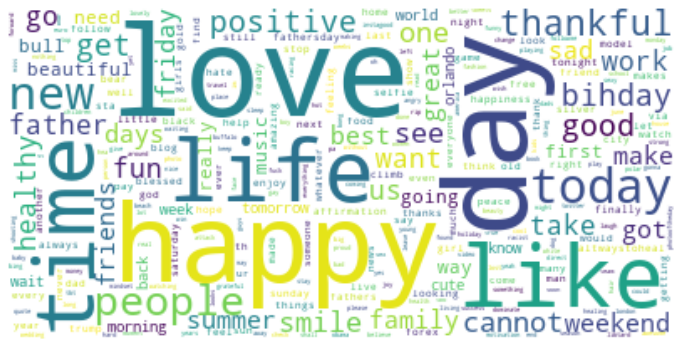

In [20]:
words = []
for line in combine_df['clean_tweet']: 
    line_words = [word for word in line.split() if word not in stop_words]
    words.extend(line_words)

wordfreq = collections.Counter(words)
wordcloud = WordCloud(
 background_color='white',
 max_words=2000,
 stopwords=stop_words
 ).generate_from_frequencies(wordfreq)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Задание 5.

Теперь отобразим облако слов для отзывов, не содержащих токсичных комментариев (combine_df['label'] == 0). 

Создадим удобную функцию

In [21]:
def draw_wordcloud(label_value, bg_color):    
    words = []
    for line in combine_df.loc[combine_df['label'] == label_value, 'clean_tweet']: 
        line_words = [word for word in line.split() if word not in stop_words]
        words.extend(line_words)

    wordfreq = collections.Counter(words)
    wordcloud = WordCloud(
    background_color=bg_color,
    max_words=2000,
    stopwords=stop_words
    ).generate_from_frequencies(wordfreq)
    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

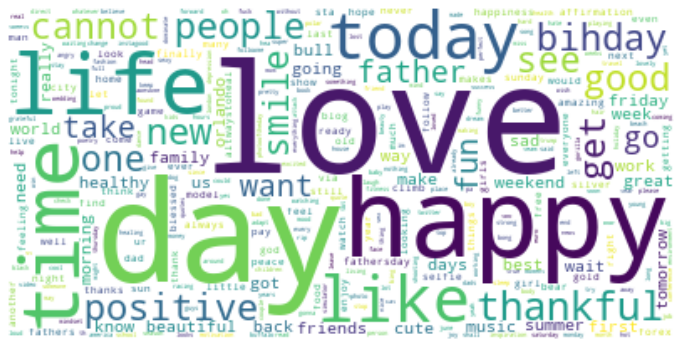

In [22]:
draw_wordcloud(0, 'white')

### Задание 6.

Теперь отобразим облако слов для отзывов, содержащих токсичные комментарии (combine_df['label'] == 1). 

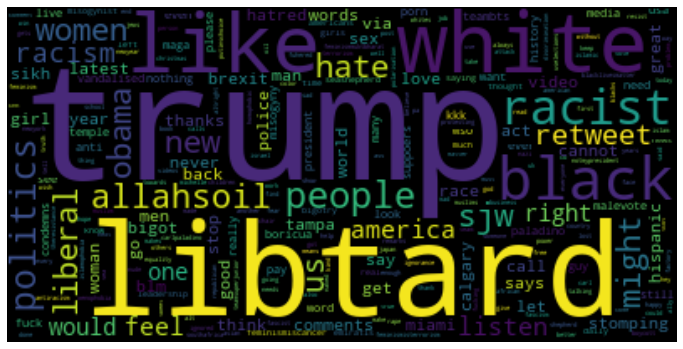

In [23]:
draw_wordcloud(1, 'black')

**Вывод:** в ходе выполнения работы прогнали часть второго домашнего задания. Получены разреженные матрицы, используя CountVectorizer, TfidfVectorizer для 'tweet_stemmed' и 'tweet_lemmatized' столбцов (4 матрицы).